# Model Prototyping

## Imports

In [ ]:
!pip install transformers
!pip install textacy

In [ ]:
# Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import os
from tqdm import tqdm

# Machine learning
from sklearn.model_selection import train_test_split

# PyTorch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

# Google drive files for data
from google.colab import drive
drive.mount('/content/drive')

## Prototyping using huggingface transformers

In [ ]:
from transformers import AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False, normalization=True)

# INPUT TWEET IS ALREADY NORMALIZED!
line = "SC has first two presumptive cases of coronavirus , DHEC confirms HTTPURL via @USER :cry:"

input_ids = torch.tensor([tokenizer(line, padding="max_length", max_length=64, truncation=True).input_ids])


Let's check for how many tokens we'll need

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Machine Learning/Datasets/Disaster Tweets/train.csv")

In [ ]:
max = 0 
for text in data['text']:
  input_ids = tokenizer(text).input_ids
  max = np.max((max, len(input_ids)))

In [ ]:
print(max)

We can see the maximum number of tokens is 64, to take into account the fact that tweets from the test set may be longer, we'll set the max number of tokens to 90, this will speed the training.

In [ ]:
output = tokenizer.encode(line)
print(output)

In [ ]:
output_dict = tokenizer.encode_plus(line, add_special_tokens=True, max_length=90, padding='max_length', return_attention_mask=True, return_tensors='pt')
input_ids = output_dict.input_ids
attention_mask = output_dict.attention_mask

In [ ]:
input_ids

In [ ]:
attention_mask

## Data prep

In [ ]:
import html
import re

# define clean function
# add / remove any line if necessary
def clean(text):
    # convert html escapes like &amp; by their plain-text representation
    text = html.unescape(text) 
    
    # subsitute tags like <tab> by spaces in the specified text or remove them
    text = re.sub(r'<[^<>]*>', ' ', text)
    
    # subsitute markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    
    # subsitute text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    
    # subsitute standalone sequences of specials, matches &# but NOT #hashtag
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)

     # subsitute standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    
    #remove stock market tickers like $GE
    text = re.sub(r'\$\w*', '', text)  
    
    #remove old style retweet text "RT"
    text = re.sub(r'RT[\s]+', '', text)        
    text = re.sub(r'DT[\s]+', '', text)   
    
    #remove hashtags
    text = re.sub(r'#', '', text)
    
    return text.strip()

In [ ]:
from textacy import preprocessing
from functools import partial

# create cleaning pipeline
preproc = preprocessing.make_pipeline(
    
    # join words split by a hyphen or line break
    preprocessing.normalize.hyphenated_words,
    
    # subsitute fancy quatation marks with an ASCII equivalent
    preprocessing.normalize.quotation_marks,
    
    # normalize unicode characters in text into canonical forms
    preprocessing.normalize.unicode,
    
    # remove any accents character in text by replacing them with ASCII equivalents or removing them entirely
    preprocessing.remove.accents,

    # remove all email addresses in text 
    partial(preprocessing.replace.emails, repl= ""), # or _EMAIL_
    
    # remove all phone numbers in text 
    partial(preprocessing.replace.phone_numbers, repl=""), # or _PhoneNumber_
    
    # remove all URLs in text 
    partial(preprocessing.replace.urls, repl= ""), # or _URL_
    
    # remove all (Twitter-style) user handles in text 
    partial(preprocessing.replace.user_handles, repl=""), # or _HANDLE_
    
    # Replace all hashtags in text with repl.
    #partial(preprocessing.replace.hashtags, repl="_HASTAG_"),
    
    ### TEST ### Enable it only before generating tokens for word clouds
    partial(preprocessing.replace.numbers, repl=""),
    
    # remove HTML tags from text
    preprocessing.remove.html_tags,

    # remove text within curly {}, square [], and/or round () brackets
    preprocessing.remove.brackets,

    # replace specific set of punctuation marks with whitespace
    partial(preprocessing.remove.punctuation, only=[ ",", ":", ";", "/", " ","(","@"]),
    
    # Replace all currency symbols in text with repl
    preprocessing.replace.currency_symbols,
    
    # replace all emoji and pictographs in text with repl.
    preprocessing.replace.emojis,
    
 )

In [ ]:
# Preprocessing
data['text_c'] = data['text'].apply(clean)
data['text_clean'] = data['text_c'].apply(preproc)
data['text_clean'] = data['text_clean'].str.lower()

In [ ]:
input_ids = []
attention_masks = []

tweets = data['text'].to_list()

for tweet in tweets:
  output_dict = tokenizer.encode_plus(tweet, add_special_tokens=True, max_length=90, padding='max_length', return_attention_mask=True, return_tensors='pt')
  input_ids.append(output_dict.input_ids)
  attention_masks.append(output_dict.attention_mask)

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

labels = torch.tensor(data['target'].values)

In [ ]:
from torch.utils.data import TensorDataset, random_split, DataLoader

dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.85 * len(dataset)) # 85 - 15 % split
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 32 # Bigger values will increase the gradient precision, lower values will reduce the memory load

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)

## Train model

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels = 2, output_attentions = False, output_hidden_states = False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-5, betas = (0.9, 0.999), eps = 1e-8)

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

epochs = 20

total_steps = len(train_dataloader) * epochs

scheduler = ReduceLROnPlateau(optimizer, mode = 'min', patience = 5)

metrics = {
    "epochs" : [],
    "train_losses" : [],
    "val_losses" : [],
    "val_accs" : [],
    "lr" : [],
}

pbar = tqdm(range(epochs))

for i, epoch in enumerate(pbar):
  model.train()

  total_train_loss = 0
  for i, batch in enumerate(train_dataloader):

    input_ids = batch[0].to(device)
    input_masks = batch[1].to(device)
    labels = batch[2].to(device)

    model.zero_grad()

    result = model(input_ids, token_type_ids = None, attention_mask = input_masks, labels = labels, return_dict = True)

    loss = result.loss
    logits = result.logits

    total_train_loss += loss.item()

    loss.backward()

    optimizer.step()

  avg_train_loss = total_train_loss / len(train_dataloader)

  total_val_acc = 0
  total_val_loss = 0
  
  model.eval()
  for i, batch in enumerate(val_dataloader):

    input_ids = batch[0].to(device)
    input_masks = batch[1].to(device)
    labels = batch[2].to(device)

    with torch.no_grad():

      result = model(input_ids, token_type_ids = None, attention_mask = input_masks, labels = labels, return_dict = True)

    loss = result.loss
    logits = result.logits.detach().cpu().numpy()
    labels = labels.cpu().numpy()

    preds = np.argmax(logits, axis = 1).flatten()
    labels = labels.flatten()

    val_acc = np.sum(preds == labels) / len(labels)

    total_val_acc += val_acc
    total_val_loss += loss.item()
  
  avg_val_loss = total_val_loss / len(val_dataloader)
  avg_val_acc = total_val_acc / len(val_dataloader)

  metrics['lr'].append(optimizer.param_groups[0]['lr'])

  scheduler.step(avg_val_loss)

  metrics['epochs'].append(epoch)
  metrics['train_losses'].append(avg_train_loss)
  metrics['val_losses'].append(avg_val_loss)
  metrics['val_accs'].append(avg_val_acc)
  
  pbar.set_postfix({'train_loss': avg_train_loss, 'val_loss': avg_val_loss, 'val_acc' : avg_val_acc})

  if (epoch + 1) % 10 == 0:
    # Saving the fine tunned model
    ckpt = {
        'epoch' : epoch,
        'model_state' : model.state_dict(),
        'optimizer_state' : optimizer.state_dict()
    }
    torch.save(ckpt, "/content/drive/MyDrive/Machine Learning/Models/weights_bertweet_intermediate.pt")

# Saving the fine tunned model
ckpt = {
        'epoch' : epoch,
        'model_state' : model.state_dict(),
        'optimizer_state' : optimizer.state_dict()
    }
torch.save(ckpt, "/content/drive/MyDrive/Machine Learning/Models/weights_bertweet_final.pt")

In [ ]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)

plt.plot(metrics['train_losses'], label='train loss')
plt.plot(metrics['val_losses'], label='val loss')
plt.xlabel("epoch")
plt.legend()
plt.title('Loss')

plt.subplot(1, 3, 2)
plt.plot(metrics['val_accs'], label='val acc')
plt.xlabel("epoch")
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 3, 3)
plt.plot(metrics['lr'], label='lr')
plt.xlabel("epoch")
plt.legend()
plt.title('Learning rate')

In [ ]:
def make_confusion_heatmap(
        cf,
        group_names=None,
        categories="auto",
        count=True,
        percent=True,
        cbar=True,
        xyticks=True,
        xyplotlabels=True,
        sum_stats=True,
        figsize=None,
        cmap="Blues",
        title=None,
):
    """
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.
    """

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ["" for i in range(cf.size)]

    if group_names and len(group_names) == cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = [
            "{0:.2%}".format(value) for value in cf.flatten() / np.sum(cf)
        ]
    else:
        group_percentages = blanks

    box_labels = [
        f"{v1}{v2}{v3}".strip()
        for v1, v2, v3 in zip(group_labels, group_counts, group_percentages)
    ]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        # Accuracy is sum of diagonal divided by total observations
        accuracy = np.trace(cf) / float(np.sum(cf))

        # if it is a binary confusion matrix, show some more stats
        if len(cf) == 2:
            # Metrics for Binary Confusion Matrices
            precision = cf[1, 1] / sum(cf[:, 1])
            recall = cf[1, 1] / sum(cf[1, :])
            f1_score = 2 * precision * recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy, precision, recall, f1_score
            )
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize == None:
        # Get default figure size if not set
        figsize = plt.rcParams.get("figure.figsize")

    if xyticks == False:
        # Do not show categories if xyticks is False
        categories = False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(
        cf,
        annot=box_labels,
        fmt="",
        cmap=cmap,
        cbar=cbar,
        xticklabels=categories,
        yticklabels=categories,
    )

    if xyplotlabels:
        plt.ylabel("True label")
        plt.xlabel("Predicted label" + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
      plt.title(title)

In [89]:
from sklearn.metrics import confusion_matrix

def get_preds(dataloader, model, device = 'cpu'):
  
  all_labels = torch.tensor([])
  all_preds = torch.tensor([])

  model.eval()
  for i, batch in enumerate(dataloader):

      input_ids = batch[0].to(device)
      input_masks = batch[1].to(device)
      labels = batch[2].to(device)

      with torch.no_grad():
        result = model(input_ids, token_type_ids = None, attention_mask = input_masks, labels = labels, return_dict = True)

      loss = result.loss
      logits = result.logits.detach().cpu()
      labels = labels.cpu()

      preds = torch.argmax(logits, axis = 1).flatten()
      labels = labels.flatten()

      all_labels = torch.cat((all_labels, labels), dim=0)
      all_preds = torch.cat((all_preds, preds), dim=0)

  return all_labels, all_preds

In [90]:
all_labels, all_preds = get_preds(val_dataloader, model, device)
cm = confusion_matrix(all_labels, all_preds)

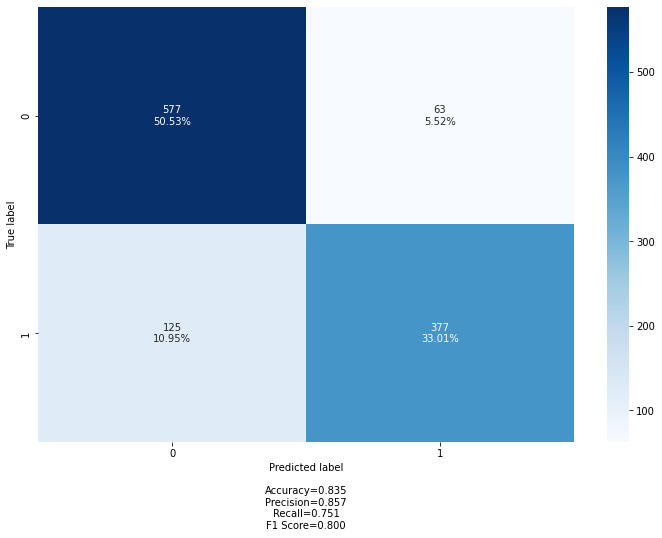

In [91]:
make_confusion_heatmap(cm, figsize=(12,8))

It has a bad recall, so one thing we could do is increase the weight for minority labels

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(all_labels, all_preds)

What is weird is that the model directly losses accuracy when we train it. It should gain in accuracy when we train it on a dowstream task. 

The val loss is increasing way too much, it's overfitting. 
What we should do :

- [x] Track the learning rate
- [x] Call the scheduler after the validation step
- [ ] Try different warmup steps
- [x] Change the scheduler type

## Make a submission

In [70]:
test_data = pd.read_csv("/content/drive/MyDrive/Machine Learning/Datasets/Disaster Tweets/test.csv")

In [72]:
input_ids = []
attention_masks = []

tweets = test_data['text'].to_list()

for tweet in tweets:
  output_dict = tokenizer.encode_plus(tweet, add_special_tokens=True, max_length=90, padding='max_length', return_attention_mask=True, return_tensors='pt')
  input_ids.append(output_dict.input_ids)
  attention_masks.append(output_dict.attention_mask)

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

In [74]:
from torch.utils.data import TensorDataset, random_split, DataLoader

dataset = TensorDataset(input_ids, attention_masks)

test_dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = False)

In [75]:
all_preds = torch.tensor([])

model.eval()
for i, batch in enumerate(test_dataloader):

  input_ids = batch[0].to(device)
  input_masks = batch[1].to(device)

  with torch.no_grad():
    result = model(input_ids, token_type_ids = None, attention_mask = input_masks, return_dict = True)

    logits = result.logits.detach().cpu()

    preds = torch.argmax(logits, axis = 1).flatten()

    all_preds = torch.cat((all_preds, preds), dim=0)

In [87]:
ids = test_data['id']
preds = pd.DataFrame(list(all_preds.type(torch.int)), columns = ['target'])
res = pd.merge(ids, preds, left_index = True, right_index = True)

In [88]:
res.to_csv("/content/drive/MyDrive/Machine Learning/Datasets/Disaster Tweets/res.csv", sep = ",", index = False)